In [2]:
import torch
import torchvision
from torchvision import transforms

In [3]:
# create transformation for our images (normalize + toTensor)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Download CIFAR10 dataset and apply transformations to training data
trainset = torchvision.datasets.CIFAR10(root='../data/train_data/', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [4]:
# Download CIFAR10 dataset and apply transformations to testing data
testset = torchvision.datasets.CIFAR10(root='../data/test_data/', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [5]:
# identify class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

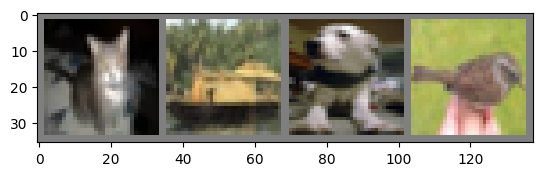

cat  ship dog  bird 


In [8]:
# grab random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Spatial Dimension Reduction Cheat Sheet
### Convolution
Output_size = $(\frac{inputSize - kernelSize + 2 * padding}{stride}) + 1$

### Max Pooling
output_size = $(\frac{inputSize - kernelSize}{stride}) + 1$

In [33]:
import torch.nn as nn

# 2. Define convolutional neural network
class Net(nn.Module):
    # define all network operations
    def __init__(self):
        super().__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input image channels (r,g,b), 6 output channels (features), 5x5 square convolution (kernel)
        self.conv2 = nn.Conv2d(6, 16, 5) # 2nd convolutional layer
        
        # Pooling Layers
        self.pool = nn.MaxPool2d(2, 2) # reduces image resolution. applies zero padding
        
        # Fully Connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # channels (16) * size of image after 2 conv & 2 pooling layers(5x5)
        self.fc2 = nn.Linear(120, 84) # in: 120 | out: 85 features
        self.fc3 = nn.Linear(84, 10) # output must match # of classifiers
        
        # Activation Function
        self.relu = nn.ReLU() # (0,x)
        
    # sequentially applies network operations on x
    def forward(self, x):
        # convolution -> activation function -> pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        # Flatten 3D tensor except batch to 1D for FFNN
        x = torch.flatten(x, 1)
        
        # Feed forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # 1 output so no activation function needed
        
        return x

In [34]:
net = Net()

In [35]:
# 3. Define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [36]:
# 4. Train the network
for epoch in range(2): # loop dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimze
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.208
[1,  4000] loss: 1.929
[1,  6000] loss: 1.721
[1,  8000] loss: 1.612
[1, 10000] loss: 1.569
[1, 12000] loss: 1.494
[2,  2000] loss: 1.421
[2,  4000] loss: 1.404
[2,  6000] loss: 1.367
[2,  8000] loss: 1.346
[2, 10000] loss: 1.326
[2, 12000] loss: 1.309
Finished Training


In [37]:
# save network
PATH = '../models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

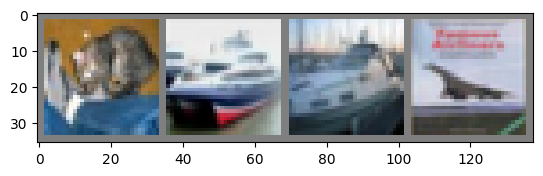

ground truth:  cat  ship ship plane


In [38]:
# 5. Test the network on new data
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(f'ground truth: ', ''.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [39]:
# we can load our saved model, but isn't necessary here
# net = Net()
# net.load_state_dict(torch.load(PATH))

In [40]:
outputs = net(images)

In [41]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   car   car  


In [42]:
# Performance
correct = 0
total = 0
# not training, so don't need to calc grads
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calc outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %
